In [1]:
import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(sys.path)
from ICL import MultiResolutionPDF



['/home/admin-quad/Toni/llmICL/figures_analysis', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/admin-quad/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/usr/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages/IPython/extensions', '/home/admin-quad/.ipython', '/home/admin-quad/Toni/llmICL', '../models']


In [2]:
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    print(f"[{index}]: {file.name}")

[0]: brownian_motion_0.pkl
[1]: brownian_motion_1.pkl
[2]: brownian_motion_10.pkl
[3]: brownian_motion_11.pkl
[4]: brownian_motion_12.pkl
[5]: brownian_motion_13.pkl
[6]: brownian_motion_14.pkl
[7]: brownian_motion_15.pkl
[8]: brownian_motion_16.pkl
[9]: brownian_motion_17.pkl
[10]: brownian_motion_18.pkl
[11]: brownian_motion_19.pkl
[12]: brownian_motion_2.pkl
[13]: brownian_motion_3.pkl
[14]: brownian_motion_4.pkl
[15]: brownian_motion_5.pkl
[16]: brownian_motion_6.pkl
[17]: brownian_motion_7.pkl
[18]: brownian_motion_8.pkl
[19]: brownian_motion_9.pkl
[20]: correlated_gaussian_0.pkl
[21]: correlated_gaussian_1.pkl
[22]: correlated_gaussian_2.pkl
[23]: correlated_gaussian_3.pkl
[24]: correlated_gaussian_4.pkl
[25]: correlated_gaussian_5.pkl
[26]: correlated_gaussian_6.pkl
[27]: correlated_gaussian_7.pkl
[28]: correlated_gaussian_8.pkl
[29]: correlated_gaussian_9.pkl
[30]: geometric_brownian_motion_0.pkl
[31]: geometric_brownian_motion_1.pkl
[32]: geometric_brownian_motion_10.pkl
[33]:

In [3]:
alpha = 1

file = all_files[52]
# file = all_files[21]
# file = all_files[4]
processed_dict = pickle.load(file.open('rb'))
full_series = processed_dict['full_series']
rescaled_true_mean_arr = processed_dict['rescaled_true_mean_arr']
rescaled_true_sigma_arr = processed_dict['rescaled_true_sigma_arr']
llama_size = processed_dict['llama_size']
mode = processed_dict['mode']
refine_depth = processed_dict['refine_depth']
random_seed = processed_dict['random_seed']
PDF_list = processed_dict['PDF_list']
time_series = processed_dict['time_series']
prec = processed_dict['prec']
print(f"seed: {processed_dict['random_seed']}")
print(f"mode: {mode}")
print(f"refine_depth: {refine_depth}")
print(f"prec: {prec}")
print(f"name: {file.stem}")

seed: 0
mode: all
refine_depth: 1
prec: 2
name: logistic_map_0


In [4]:
### tune temperature 

for PDF in PDF_list:
    if alpha != 1:
        PDF.rescale_temperature(alpha)

In [5]:
### Calculate true discretized distribution: PDF_list_true
### Compute discretized BT and KL loss

PDF_true_list = copy.deepcopy(PDF_list)
discrete_BT_loss = []
discrete_KL_loss = []
for PDF, PDF_true, true_mean, true_sigma in zip(PDF_list, PDF_true_list, rescaled_true_mean_arr, rescaled_true_sigma_arr):
    def cdf(x):
        return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
    
    PDF_true.discretize(cdf, mode = "cdf")
    PDF_true.compute_stats()
    discrete_BT_loss += [PDF_true.BT_dist(PDF)]    
    discrete_KL_loss += [PDF_true.KL_div(PDF)]

discrete_BT_loss = np.array(discrete_BT_loss)
discrete_KL_loss = np.array(discrete_KL_loss)

### Extract statistics from MultiResolutionPDF

mean_arr = []
mode_arr = []
sigma_arr = []
moment_3_arr = []
moment_4_arr = []

num_commas = full_series.count(',')
for comma_idx in range(num_commas):
    PDF_list[comma_idx].compute_stats()
    mean, mode, sigma = PDF_list[comma_idx].mean, PDF_list[comma_idx].mode, PDF_list[comma_idx].sigma 
    moment_3 = PDF_list[comma_idx].compute_moment(3)
    moment_4 = PDF_list[comma_idx].compute_moment(4)
    
    mean_arr.append(mean)
    mode_arr.append(mode)
    sigma_arr.append(sigma)
    moment_3_arr.append(moment_3)
    moment_4_arr.append(moment_4)

# Convert lists to numpy arrays
mean_arr = np.array(mean_arr)
mode_arr = np.array(mode_arr)
sigma_arr = np.array(sigma_arr)
moment_3_arr = np.array(moment_3_arr)
moment_4_arr = np.array(moment_4_arr)

error_mean = np.abs(rescaled_true_mean_arr - mean_arr)
error_mode = np.abs(rescaled_true_mean_arr - mode_arr)

<ipython-input-5-d5245540c597>:9: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/admin-quad/Toni/llmICL/models/ICL.py:417: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/admin-quad/Toni/llmICL/models/ICL.py:418: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr
<ipython-input-5-d5245540c597>:9: RuntimeWarning: invalid value encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))


In [6]:
# ### Calculate NLL
# good_tokens_str = list("0123456789" + settings.time_sep + settings.bit_sep)
# good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
# bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
# logit_mat_biased = logit_mat.clone()
# logit_mat_biased[:,:,bad_tokens] = -np.inf
# input_ids = batch['input_ids'][0][1:]

# logprobs = torch.nn.functional.log_softmax(logit_mat_biased, dim=-1)[0][:-1]
# # logprob of the full trajectory
# logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()
# NLL = -logprobs

# char_array = np.array(list(full_series))
# comma_locations = np.where(char_array == ',')[0][:-1]+1

# NLL_digit = -logprobs[comma_locations] \
#             -logprobs[comma_locations+1] \
#             -logprobs[comma_locations+2]

<ipython-input-7-1433da9a8138>:23: RuntimeWarning: divide by zero encountered in log
  BT_loss = error_mean / (rescaled_true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + rescaled_true_sigma_arr) - np.log(sigma_arr * rescaled_true_sigma_arr)/2 - np.log(2)
<ipython-input-7-1433da9a8138>:25: RuntimeWarning: divide by zero encountered in divide
  KL_loss = np.log(sigma_arr/rescaled_true_sigma_arr) + (rescaled_true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2


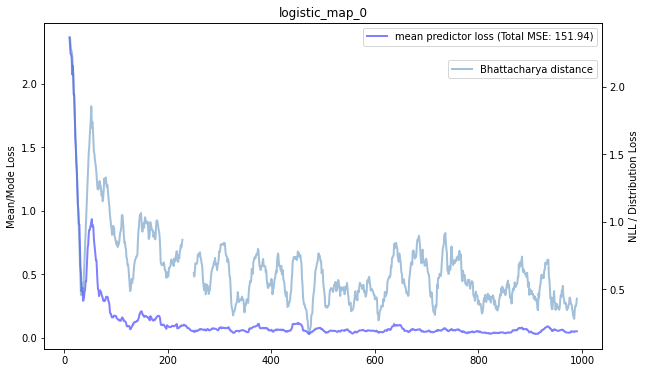

In [7]:
window_size = 20
xlog = 0
ylog = 0

scale_mean_mode_error = 0

top_hat_kernel = np.ones(window_size) / window_size
gaussian_kernel = norm.pdf(np.arange(window_size), loc=window_size // 2, scale=window_size / 6)
# kernel = gaussian_kernel
kernel = top_hat_kernel

    
averaged_error_mean = np.convolve(error_mean, kernel, mode='valid')
averaged_error_mode = np.convolve(error_mode, kernel, mode='valid')

# Errors from NLL
# averaged_nll_digit = np.convolve(NLL_digit, kernel, mode='valid')

averaged_discrete_BT_loss = np.convolve(discrete_BT_loss, kernel, mode='valid')
averaged_discrete_KL_loss = np.convolve(discrete_KL_loss, kernel, mode='valid')

# Errors from Bhattacharya distance and KL divergence
BT_loss = error_mean / (rescaled_true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + rescaled_true_sigma_arr) - np.log(sigma_arr * rescaled_true_sigma_arr)/2 - np.log(2)
averaged_BT_loss = np.convolve(BT_loss, kernel, mode='valid')
KL_loss = np.log(sigma_arr/rescaled_true_sigma_arr) + (rescaled_true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2
averaged_KL_loss = np.convolve(KL_loss, kernel, mode='valid')

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the averaged errors
# ax1.plot(np.arange(window_size//2, len(error_mode) - window_size//2 + 1), averaged_error_mode, label=f"mode predictor loss (Total MSE: {np.sum(error_mode):.2f})", linewidth=2, c='lightblue', alpha = 0.5)
ax1.plot(np.arange(window_size//2, len(error_mean) - window_size//2 + 1), averaged_error_mean, label=f"mean predictor loss (Total MSE: {np.sum(error_mean):.2f})", linewidth=2, c='blue', alpha = 0.5)

ax1.set_ylabel("Mean/Mode Loss")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
# ax2.plot(np.arange(window_size//2, len(BT_loss) - window_size//2 + 1), averaged_BT_loss, label="approx. Bhattacharya distance", linewidth=2, c='gray', alpha = 0.8)
# ax2.plot(np.arange(window_size//2, len(KL_loss) - window_size//2 + 1), averaged_KL_loss, label="approx. KL divergence", linewidth=2, c='gray', alpha = 0.8)

# ax2.plot(np.arange(window_size//2, len(NLL_digit) - window_size//2 + 1), averaged_nll_digit, label="NLL Digit Loss", linewidth=2, c='gray', alpha = 0.5)
ax2.plot(np.arange(window_size//2, len(discrete_BT_loss) - window_size//2 + 1), averaged_discrete_BT_loss, label="Bhattacharya distance", linewidth=2, c='steelblue', alpha = 0.5)
# ax2.plot(np.arange(window_size//2, len(discrete_KL_loss) - window_size//2 + 1), averaged_discrete_KL_loss, label="KL Divergence", linewidth=2, c='maroon', alpha = 0.5)

# ax1.plot(X)

ax2.set_ylabel("NLL / Distribution Loss")
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
# ax2.set_ylim(0,0.5)
if xlog:
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    
if ylog:
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    
# plt.xlim(0,150)
    
plt.xlabel("Time Steps Seen")
plt.title(f"{file.stem}")
plt.show()



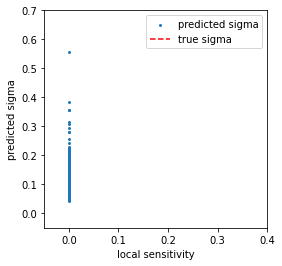

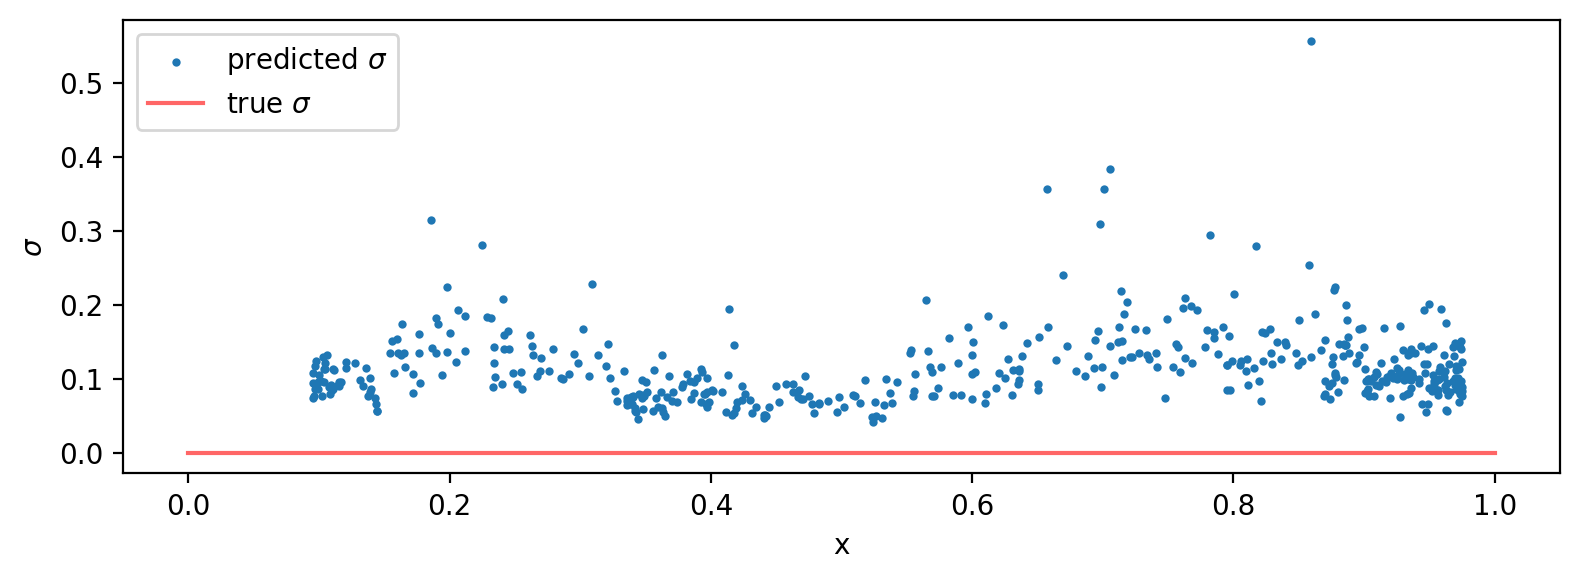

In [8]:
# plt.figure(figsize=(3, 6))
plt.figure(figsize=(4, 4))
plt.scatter(rescaled_true_sigma_arr[500:],sigma_arr[500:], marker='.', lw=0, label = 'predicted sigma')
max_val = np.max(rescaled_true_sigma_arr[500:])
min_val = 0
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label = 'true sigma')  # Add line of slope 1

plt.xlabel(r'local sensitivity')
plt.ylabel('predicted sigma')
plt.xlim(-0.05, 0.4)
plt.ylim(-0.05, 0.7)
plt.legend()
# plt.axis('equal')
# plt.loglog()

plt.figure(figsize=(8, 3), dpi = 200)
plt.scatter(time_series[500:-1], sigma_arr[501:], marker = '.', lw=0, label = r'predicted $\sigma$')
plt.plot([0, 0.5, 1],[rescaled_true_sigma_arr.max(), 0, rescaled_true_sigma_arr.max()], color='red', label = r'true $\sigma$', linestyle='-', alpha = 0.6)
plt.xlabel('x')
plt.ylabel(r'$\sigma$')
plt.legend()
plt.tight_layout()
# plt.savefig('../figures/noisy_logistic_sigma.png')



Widget Javascript not detected.  It may not be installed or enabled properly.


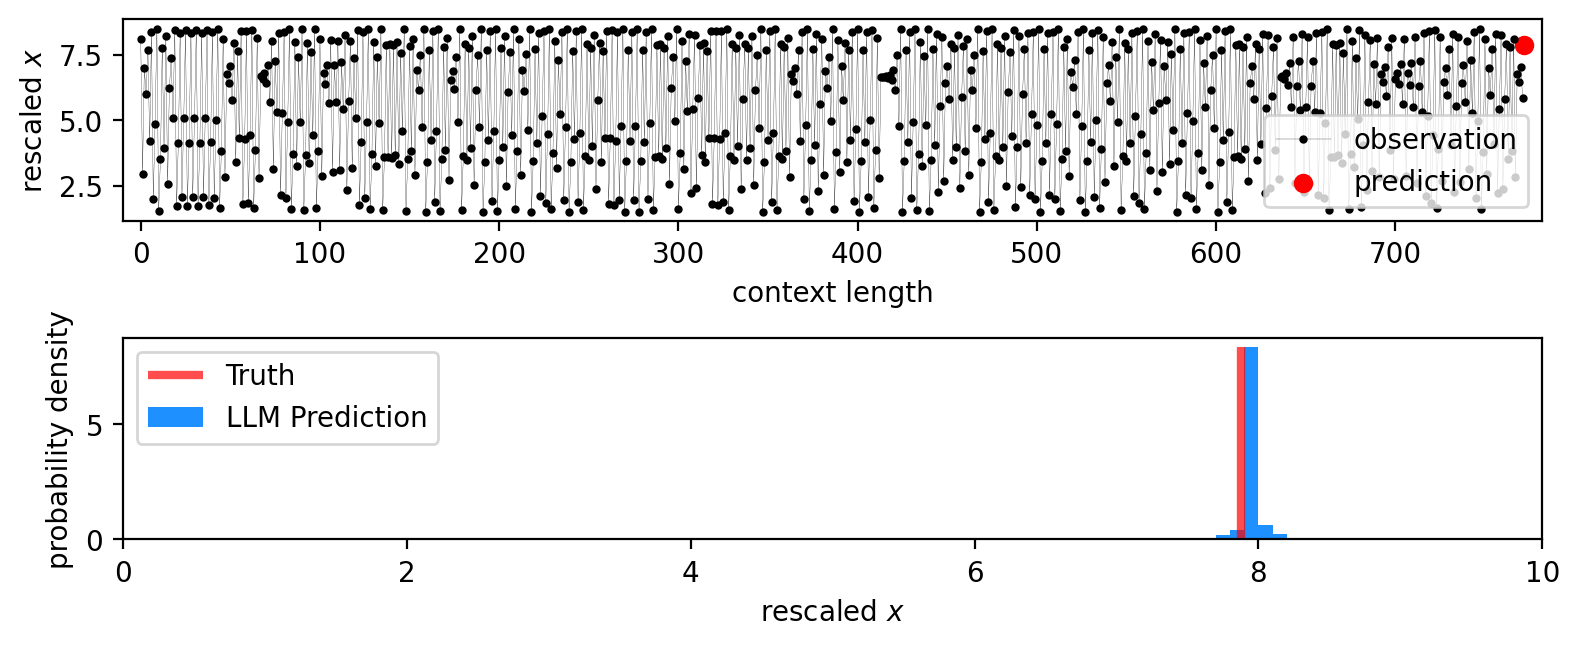

In [10]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import norm
save_path = "../figures/logistic_example.png"

### Load multiple digits to MultiResolutionPDF
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])
time_series_rescaled = (time_series-time_series.min()) / (time_series.max()-time_series.min()) * (8.5-1.5) + 1.5

plot1_log_scale = 0
log_scale = 0
truth_PDF = 0
final_state = 772
# final_state = None

### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if comma_idx == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[comma_idx-1]+1
    if truth_PDF:
        fig, axs = plt.subplots(3, 1, figsize=(8, 5), dpi = 200)
    else:
        fig, axs = plt.subplots(2, 1, figsize=(8, 10/3), dpi = 200)
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.7)
    # Plot the full array with a marker on the selected value
    if final_state is not None:
        time_series_plot = time_series_rescaled[:final_state+1]
    else:
        time_series_plot = time_series_rescaled
    axs[0].plot(time_series_plot[:-1], marker='o', color='black', markersize=2, lw = '0.1', label = "observation")
    axs[0].scatter(comma_idx, time_series_plot[comma_idx], color='r', marker='o', label = "prediction")
    axs[0].set_xlabel('context length')
    axs[0].set_ylabel(r'rescaled $x$')
    axs[0].set_xlim(-10, final_state+10)
    if plot1_log_scale:
        axs[0].set_yscale('log')
        
    # Plot softmax distributions for each digit
    axs[1].set_ylabel("probability density")
    # axs[1].set_title(full_series[start_idx-30:start_idx] + "?")      
    PDF_list[comma_idx].compute_stats()
    PDF_list[comma_idx].plot(ax = axs[1], log_scale=log_scale, statistic = False)
    if truth_PDF:
        PDF_true_list[comma_idx].plot(ax = axs[2], log_scale=log_scale, statistic = False)
        axs[2].set_title('discretized truth')
        axs[2].set_xlabel("Digit")
    
    # characterizing ground truth distribution
    true_mean = rescaled_true_mean_arr[comma_idx]
    true_sigma = rescaled_true_sigma_arr[comma_idx]
    if true_sigma == 0:
        axs[1].vlines(true_mean, 0, np.max(PDF_list[comma_idx].bin_height_arr), color='r', label='Truth', lw = 3, alpha = 0.7)
    else:
        x_values = np.linspace(0, 10, 300)
        gaussian = norm.pdf(x_values, true_mean, true_sigma)
        axs[1].plot(x_values, gaussian, color = 'r', label = 'Truth', lw = 3, alpha = 0.7)
        # axs[1].vlines(true_mean, 0, np.max(gaussian), color = 'r')
    # axs[1].set_ylim(np.min(pdf.bin_height_arr), np.max(gaussian)*1.7)
    axs[1].set_xlabel(r'rescaled $x$')
    axs[1].bar([0], [0], color='dodgerblue', label='LLM Prediction')
    axs[1].set_xlim(0,10)
    # axs[1].set_ylim(0,5)
    axs[0].legend()
    axs[1].legend()
    if log_scale:
        axs[1].set_ylim(0.0005,10)
        if truth_PDF:
            axs[2].set_ylim(0.0005,10)
    if final_state is not None: 
        plt.tight_layout()
        plt.savefig(save_path)

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
if final_state is not None: 
    interact(digiprob_plotter, comma_idx=final_state)
else:
    interact(digiprob_plotter, comma_idx=(1, num_commas-1, 1))